## Running Cosine Similarity and NYT API Requests


### Looking at NYT API Data


In [15]:
myAPIkey = "G2G9F7zgkQ6gQYd6WWjrwwzLHAtG192b"
import pandas as pd


In [16]:
import requests, json

def getNYTArticles(year, month, apiKey):
    """Function that sends a request to the NYT API for all articles in a month
    and then stores the results in a JSON file.
    """
    # create URL
    URL = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={apiKey}"

    # send the request to get the data
    data = requests.get(URL)
    if data.status_code == 200:
        print("Successfully got the data.")

    dataJson = data.json() # get response as JSON

    return dataJson

In [17]:
def write_allMonths(year, list_month, apiKey):
    year_headlines = {}
    for month in list_month:
       jsonMonth = getNYTArticles(year, month, apiKey)
       year_headlines[month] = jsonMonth
    return year_headlines

In [18]:
dataJson23 = write_allMonths(2023, [1,2,3,4,5,6,7,8,9,10,11,12], myAPIkey)
with open(f"NYT_2023.json", 'w') as fout:
        json.dump(dataJson23, fout)

Successfully got the data.
Successfully got the data.
Successfully got the data.
Successfully got the data.
Successfully got the data.
Successfully got the data.
Successfully got the data.
Successfully got the data.
Successfully got the data.
Successfully got the data.
Successfully got the data.
Successfully got the data.


In [19]:
dataJson24 = write_allMonths(2024, [1,2,3], myAPIkey)
with open(f"NYT_2024.json", 'w') as fout:
        json.dump(dataJson24, fout)

Successfully got the data.
Successfully got the data.
Successfully got the data.


In [20]:
def get_NewsDetails(jsonDate):
    json_year = {}
    for key in jsonDate.keys():
        docsList = jsonDate[key]["response"]["docs"]
        print(len(docsList))
        keywords = []
        headlines = []
        for doc in docsList: #keywords #headline
            headline = doc["headline"]["main"]
            if headline not in headlines:
                headlines.append(headline)
            for keyword in doc["keywords"]:
                if keyword not in keywords:
                    keywords.append(keyword)
        
        json_year[key] ={"headlines":headlines, "keywords":keywords}
    return json_year

json_23 = get_NewsDetails(dataJson23)
json_24 = get_NewsDetails(dataJson24)

3423
3260
5769
3718
3881
3788
3548
3668
3823
3906
3734
3525
3785
3791
2072


### Looking at Pyktok Info from our Browsed Videos

In [35]:
# splitting hashtags
import pandas as pd

df = pd.read_csv('results_AL.csv')

def clean_csvs(df):
    
    num = len(df)
    print('Total number of videos', num)

    df = df.drop_duplicates(subset=['video_id'])
    num_unique = len(df)
    print('Total number of unique videos', num_unique)

    # drop all videos where video_description are NaN
    df.dropna(subset=['video_description'], how='all', inplace=True)
    num_no_sugg_descr = num_unique-len(df)

    print("Total Videos Without description", num_no_sugg_descr)

    # drop all videos not created in US
    df_english = df[df['video_locationcreated'].isin(['US', 'CA', 'GB'])]
    without_US = len(df_english)

    print("Total Videos Not Created In US, CA, or GB:",len(df)-without_US)

    df_english['video_date'] = df_english['video_timestamp'].str[:10]

    print("Total Videos After Cleaning:",len(df_english))

    return df_english

df_english = clean_csvs(df)
# cosine similarity between nyt headlines and tiktok descritption, suggested words, and transcripts

Total number of videos 1853
Total number of unique videos 1774
Total Videos Without description 135
Total Videos Not Created In US, CA, or GB: 324
Total Videos After Cleaning: 1315


C:\Users\ashle\AppData\Local\Temp\ipykernel_5844\198383210.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['video_description'], how='all', inplace=True)
C:\Users\ashle\AppData\Local\Temp\ipykernel_5844\198383210.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_english['video_date'] = df_english['video_timestamp'].str[:10]


In [59]:
# create new column with just the date

df_english.to_csv('english_nytTiktokData.csv', index=False)


C:\Users\ashle\AppData\Local\Temp\ipykernel_12028\2796349659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_english['video_date'] = df_english['video_timestamp'].str[:10]


In [3]:
#pip install wordninja
import wordninja


In [16]:
combined_string = "replying to adrian movie good boy full spoilershorror goodboymovie movie movierecommendation horrortok horrorstory horrormovie horrorfilm scary"

# Split the combined string into separate words
words = wordninja.split(combined_string)

print(words)

['replying', 'to', 'adrian', 'movie', 'good', 'boy', 'full', 'spoilers', 'horror', 'good', 'boy', 'movie', 'movie', 'movie', 'recommendation', 'horror', 'tok', 'horror', 'story', 'horror', 'movie', 'horror', 'film', 'scary']


In [5]:
# access relevant columns
import string
import re
from nltk.corpus import stopwords

df = pd.read_csv('english_nytTiktokData.csv')

def isolate_vars(df):
    df = df[['video_id', 'video_date', 'video_description', 'suggested_words']]

    df = df.dropna(subset=['video_date'])
    # Process 'video_description' column
    for index, row in df.iterrows():
        value = row['video_description']
        words = [char for char in value.lower().split() if char not in string.punctuation]
        words = [re.sub(r'[^\w\s]', '', word).lower() for word in words]
        words = [re.sub(r'\d+', '', word) for word in words]
        words = [item for item in words if item != '']
        words = [word for word in words if word not in ['fyp', 'foryou', 'fypシ', 'foryoupage']]
        # sentence = ' '.join(words)
        # words = wordninja.split(sentence)
        sentence = ' '.join(words)
        df.at[index, 'video_description'] = sentence

        #print(sentence)

    for index, row in df.iterrows():
        value = row['suggested_words']
        if isinstance(value, str):  # Check if value is a string
            words = [char for char in value.lower().split() if char not in string.punctuation]
            words = [re.sub(r'[^\w\s]', '', word).lower() for word in words]
            words = [re.sub(r'\d+', '', word) for word in words]
            words = [item for item in words if item != '']
            words = [word for word in words if word not in ['fyp', 'foryou', 'fypシ', 'foryoupage']]
            # sentence = ' '.join(words)
            # words = wordninja.split(sentence)
            sentence = ' '.join(words)
            df.at[index, 'suggested_words'] = sentence
        else:
            sentence = None
            df.at[index, 'suggested_words'] = sentence
    return df
df_isolate =isolate_vars(df)

c:\Users\ashle\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [197]:
column_names = df_isolate.columns.tolist()
print(column_names)

df_isolate.to_csv('cleaned_nytTiktokData.csv', index=False)


['video_id', 'video_date', 'video_description', 'suggested_words']


In [26]:
# add [suggested_words] and [titles] to df dataframe for each row
# dataJson24.keys()
# dataJson23.keys()
# Save DataFrame to CSV without index
df = pd.read_csv('cleaned_nytTiktokData.csv')

def get_nytDetails(date, json_23, json_24):
    date = date.split("-")
    year = int(date[0])
    month = int(date[1])
    
    try:
        if year == 2023:
            words = json_23[month]["keywords"]
            all_words = []
            for word in words:
                all_words.append(word['value'])
            titles = json_23[month]["headlines"]
        elif year == 2024:
            words = json_24[month]["keywords"]
            titles = json_24[month]["headlines"]
            all_words = []
            for word in words:
                all_words.append(word['value'])
        else:
            words = []
            all_words = []
            for word in words:
                all_words.append(word['value'])
            titles = []
            print(f'{year} Year not in Collected Data')

    except KeyError:
        print(f'({month}) month is not in Collected Data for year {year}')
        titles = []
        all_words = []

    return all_words, titles
        
             
keywords, headlines = get_nytDetails("2024-01-20",json_23,json_24)
print(headlines)
print(keywords)


['PGA Tour and Saudi-Backed LIV Extend Deadline to Finalize Deal', 'Something to Whistle', 'U.S. Helicopters Sink 3 Houthi Boats in Red Sea, Pentagon Says', 'In Times Square, Hundreds of Thousands Ring In 2024', 'Quotation of the Day: In a Jewish-Arab School, an Oasis From Division but Not From Deep Fears', 'Half of Gazans Are at Risk of Starving, U.N. Warns', 'How to Start the New Year? Keep the Sea Goddess Happy.', 'What’s Sapping Your Energy?', 'Day 1: A 5-Minute Trick for More Energy', 'Monday Briefing', 'What’s on TV This Week: ‘RuPaul’s Drag Race’ and the Golden Globes', 'Today’s Wordle Review', 'Spelling Bee Forum', 'The Connections Companion', 'It’s 2024. Here Are the New Laws That New Yorkers Should Know About.', 'The Well Team Knows You’re Tired. And They’re Here to Help.', 'New State Laws on Hot-Button Issues Take Effect Today', 'Can New Haven’s Legendary Pizza Joints Play on the National Stage?', 'Chill in the Housing Market Seeps Into Other Industries', 'Firecrackers and I

In [27]:
def clean_nyt(value):
    fixed = []
    for v in value:
        words = [char for char in v.lower().split() if char not in string.punctuation]
        words = [re.sub(r'[^\w\s]', '', word).lower() for word in words]
        words = [re.sub(r'\d+', '', word) for word in words]
        sentence = ' '.join(words)
        fixed.append(sentence)
    return fixed  
clean_nyt(headlines)

['pga tour and saudibacked liv extend deadline to finalize deal',
 'something to whistle',
 'us helicopters sink  houthi boats in red sea pentagon says',
 'in times square hundreds of thousands ring in ',
 'quotation of the day in a jewisharab school an oasis from division but not from deep fears',
 'half of gazans are at risk of starving un warns',
 'how to start the new year keep the sea goddess happy',
 'whats sapping your energy',
 'day  a minute trick for more energy',
 'monday briefing',
 'whats on tv this week rupauls drag race and the golden globes',
 'todays wordle review',
 'spelling bee forum',
 'the connections companion',
 'its  here are the new laws that new yorkers should know about',
 'the well team knows youre tired and theyre here to help',
 'new state laws on hotbutton issues take effect today',
 'can new havens legendary pizza joints play on the national stage',
 'chill in the housing market seeps into other industries',
 'firecrackers and ice  mustsee festivals in 

## Starting cosine and embedding

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [10]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [11]:
from numpy.linalg import norm

def cosineSimilarity(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    V1 = np.array(vec1)
    V2 = np.array(vec2)
    cosine = np.dot(V1, V2)/(norm(V1)*norm(V2))
    return cosine

In [12]:
def pairwiseSimilarity(df,json_23,json_24):
    """Given a matrix of embeddings for words or sentences,
    calculate the cosine similarity for each pair.
    """
    df['score_news'] = None
    for index, row in df.iterrows():
        list1 = row['video_description']
        list2 = row['suggested_words']
        if pd.isna(list1):
            video_details = []
        elif pd.isna(list2) and not pd.isna(list1):
            video_details = list1
        else:
            video_details = list1+list2

        date = row['video_date']
        nyt_keywords,nyt_headlines = get_nytDetails(date,json_23,json_24)
        try:
            if len(nyt_keywords) > 0 and len(nyt_headlines) > 0 and len(video_details) > 0:
                nyt_headlines = clean_nyt(nyt_headlines)
                nyt_headlines = [' '.join(nyt_headlines)]
                
                video_details = embed([video_details])
                nyt_headlines = embed(nyt_headlines)
                
                cos_score = cosineSimilarity(video_details[0], nyt_headlines[0])
            else:
                cos_score = None
            df.at[index, 'score_news'] = cos_score
        except Exception as e:
            print(f'Error found on {row["video_id"]}')
            cos_score = None
            df.at[index, 'score_news'] = cos_score

    return df

In [170]:
df_scores = pairwiseSimilarity(df,json_23,json_24)
print(df_scores)

replying to ffredinho_ wifes perspective my wife has been insisting that we have a way with my sister when i put my foot down and told her no she took matters into her own hands reddit redditstories redditreadings askreddit satisfying redditfeeds this story may be adapted for more entertainment
replying to connormalloy update my wife has been insisting that we have a way with my sister when i put my foot down and told her no she took matters into her own hands reddit redditstories redditreadings askreddit satisfying redditfeeds this story may be adapted for more entertainment
my wife has been insisting that we have a way with my sister when i put my foot down and told her no she took matters into her own hands reddit redditstories redditreadings askreddit satisfying redditfeeds this story may be adapted for more entertainment
dateideas redthoughts viral love
for yall who always want to see more weve gone full out impacted hair follicle plucking greatdane doggrooming grossola satisfying

In [178]:
#df_scores.to_csv('tiktokNytScores.csv', index=False, float_format='%.0f')
max_score = df_scores['score_news'].max()
print(max_score)
max_score_video_id = df.loc[df['score_news'].idxmax(), 'video_description']
print(max_score_video_id)

0.39215237
taylor swift taylorswift shakeitoff square tiananmensquare tiananmensquare tragedy notcool notcoolbro tragic tragicstory chinese china chinatiktok taylorsversion taylorswifterastour taylorswiftedit politics politicstiktok xijingping xijinping donaldtrump joebiden tank war meme memes memestiktok


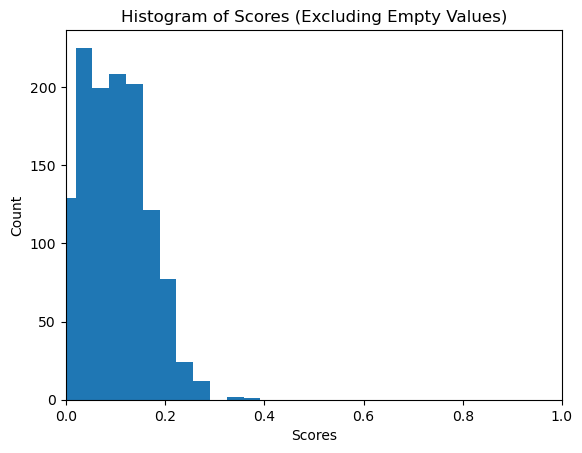

In [189]:
import matplotlib.pyplot as plt

df_filtered = df_scores.dropna(subset=['score_news'])

plt.hist(df_filtered['score_news'], bins=15)  # Adjust number of bins as needed
plt.xlabel('Scores')
plt.ylabel('Count')
plt.title('Histogram of Scores (Excluding Empty Values)')
plt.xlim(0, 1)

plt.show()

## Running cosine scoring on all videos

In [33]:
import os
import pandas as pd

# Path to the folder containing CSV files
folder_path = r"C:\Users\ashle\OneDrive\School\CS315_Project2\CS315Project2-main\CS315Project2-main\raw_tiktokData\pyktok_data"

dfs = []
print(f'{len(os.listdir(folder_path))}')

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        dfs.append(pd.read_csv(file_path))

combined_df = pd.concat(dfs, ignore_index=True)
combined_df.to_csv('combined_df.csv', index=False)

6


In [36]:
cleanDf =clean_csvs(combined_df)
allDf = isolate_vars(cleanDf)
allDf.to_csv('allCleanData.csv', index=False)

df_scores = pairwiseSimilarity(allDf,json_23,json_24)
print(df_scores)

Total number of videos 9330
Total number of unique videos 7952
Total Videos Without description 419
Total Videos Not Created In US, CA, or GB: 1619
Total Videos After Cleaning: 5914


C:\Users\ashle\AppData\Local\Temp\ipykernel_5844\198383210.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['video_description'], how='all', inplace=True)
C:\Users\ashle\AppData\Local\Temp\ipykernel_5844\198383210.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_english['video_date'] = df_english['video_timestamp'].str[:10]


2021 Year not in Collected Data
2022 Year not in Collected Data
2021 Year not in Collected Data
2021 Year not in Collected Data
2022 Year not in Collected Data
2022 Year not in Collected Data
2022 Year not in Collected Data
2022 Year not in Collected Data
2021 Year not in Collected Data
2021 Year not in Collected Data
2021 Year not in Collected Data
2021 Year not in Collected Data
2021 Year not in Collected Data
2022 Year not in Collected Data
2022 Year not in Collected Data
2022 Year not in Collected Data
2022 Year not in Collected Data
2021 Year not in Collected Data
2022 Year not in Collected Data
2022 Year not in Collected Data
2022 Year not in Collected Data
2022 Year not in Collected Data
2021 Year not in Collected Data
2022 Year not in Collected Data
2022 Year not in Collected Data
2021 Year not in Collected Data
2022 Year not in Collected Data
2022 Year not in Collected Data
2022 Year not in Collected Data
2022 Year not in Collected Data
2021 Year not in Collected Data
2022 Yea

In [215]:
df_scores
#cosineSimilarites.csv

,video_id,video_date,video_description,suggested_words,score_news
0,7.315229e+18,2023-12-21,replying to ffredinho_ wifes perspective my wi...,my wife has been insisting we have a wifes per...,None
1,7.315223e+18,2023-12-21,replying to connormalloy update my wife has be...,my wife has been insisting we have a storytell...,None
2,7.315212e+18,2023-12-21,my wife has been insisting that we have a way ...,None,None
3,7.315089e+18,2023-12-21,dateideas redthoughts viral love,None,None
4,7.306701e+18,2023-11-28,for yall who always want to see more weve gone...,impacted hair follicles waxing impacted hair f...,None
...,...,...,...,...,...
9302,7.119514e+18,2022-07-12,how he doesnt curse is is above me straykids f...,felix keycard video felix cursing because he l...,None
9316,7.334504e+18,2024-02-11,rightfull so i mean iland sunghoon sunghoonila...,sunghoon kyungmin and sunghoon heeseung iland ...,None
9322,7.238290e+18,2023-05-28,jakecurly nathalycuevas jake nat,nathalyycuevas jake and nathaly jake edit nath...,None
9323,7.261580e+18,2023-07-30,hes so fine jake enhypen,jake enhypen jake fate tour jake edit heesung ...,None
